In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Flatten, LSTM,GRU, Conv1D,MaxPooling1D,Dropout,Activation,SpatialDropout1D,Bidirectional,BatchNormalization
from keras.layers.embeddings import Embedding
from keras.models import load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn import metrics
import nltk
import string
import statistics
from nltk.corpus import stopwords
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [0]:
#Read training data
path="/content/drive/My Drive/Toxic Project/train.csv"
train_data=pd.read_csv(path)
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [0]:
#check null values
train_data.columns.isna()

array([False, False, False, False, False, False, False, False])

In [0]:
#extract y values
y_train=np.array(train_data.drop(['id','comment_text'],axis=1))
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [0]:
#read test data
path_test="/content/drive/My Drive/Toxic Project/test.csv"
test_data=pd.read_csv(path_test)
test_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [0]:
#read test label
test_label_path="/content/drive/My Drive/Toxic Project/test_labels.csv"
test_label=pd.read_csv(test_label_path)
y_test=test_label.iloc[:,1:7]
y_test[y_test==-1]=1
y_test

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1
...,...,...,...,...,...,...
153159,1,1,1,1,1,1
153160,1,1,1,1,1,1
153161,1,1,1,1,1,1
153162,1,1,1,1,1,1


# **Pre-Processing**

Remove stop words and stemmers

In [0]:
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def clean_text_sequence(x):
    #clean punctuation 
    x=x.translate(string.punctuation)
    
    #convert text to lower case
    x=x.lower()

    #split the words
    x=x.split()
    
    #remove stop words
    remove_stopwords_list=set(stopwords.words("english"))
    
    #select the threshold
    new_word_list=[word for word in x if not word in  remove_stopwords_list and len(word)>3 ]

            
    text=" ".join(new_word_list)
    
    #clean the text
    #extracted by https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r'\s+', ' ', text)
    
    #remove stemming i.e. overfitting>>>>overfit
    
    text_new=text.split()
    stemmer_type=SnowballStemmer('english')
    stemmed_words=[stemmer_type.stem(word) for word in text_new ]
    

        
    text_stemmed=" ".join(stemmed_words)
    
    return text_stemmed
    
            
    


In [0]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [0]:
x_train=train_data['comment_text'].map(lambda x:clean_text_sequence(x) )
x_test=test_data['comment_text'].map(lambda x:clean_text_sequence(x) )

Add impolite word list

In [0]:
unpolite_word_path="/content/drive/My Drive/Toxic Project/unpolite_word_list1.txt"
unpolite_words=pd.read_csv(unpolite_word_path,encoding='utf-8')
unpolite_words_list=unpolite_words.iloc[:,0].tolist()

In [0]:
!apt install -qq enchant
!pip install pyenchant

The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 7 not upgraded.
Need to get 1,310 kB of archives.
After this operation, 5,353 kB of additional disk space will be used.
Preconfiguring packages ...
Selecting previously unselected package libtext-iconv-perl.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../0-libte

check and remove non English words

In [0]:
#check the x_train sequence is in English or not. Non English words are excluded
import enchant
new_x_train_list=[]
dict = enchant.Dict("en_US")

for x in x_train:
  temp_seq=""
  temp_word_list = x.split(" ")
  for y in range(len(temp_word_list)):
    if not temp_word_list[y]:
      continue
    if temp_word_list[y] in unpolite_words_list:
      temp_seq=temp_seq+temp_word_list[y] + " "
    elif dict.check(temp_word_list[y]):
      temp_seq=temp_seq+temp_word_list[y] + " "
  new_x_train_list.append(temp_seq)

In [0]:
#check the x_test sequence is in English or not. Non English words are excluded
import enchant
new_x_test_list=[]
dict = enchant.Dict("en_US")

for x in x_test:
  temp_seq=""
  temp_word_list = x.split(" ")
  for y in range(len(temp_word_list)):
    if not temp_word_list[y]:
      continue
    if temp_word_list[y] in unpolite_words_list:
      temp_seq=temp_seq+temp_word_list[y] + " "
    elif dict.check(temp_word_list[y]):
      temp_seq=temp_seq+temp_word_list[y] + " "
  new_x_test_list.append(temp_seq)

Tokenize the words

In [0]:
unique_words=5000 #maximum number of words for embedding
tokenizer=Tokenizer(num_words=unique_words)
tokenizer.fit_on_texts(new_x_train_list)
tokenizer.fit_on_texts(new_x_test_list)

Add tokens for the impolite word list

In [0]:
word_index = tokenizer.word_index
size=len(unpolite_words_list)

count=0
word_list_temp=unpolite_words_list
for w, index in word_index.items():
    if w in unpolite_words_list:
        word_list_temp.remove(w)
        count+=1 
    if index > (unique_words-size+count):
        for u_w in word_list_temp:
            tokenizer.word_index[u_w] = index
            index+=1
        break

In [0]:
x_train_seq = tokenizer.texts_to_sequences(new_x_train_list)
x_test_seq = tokenizer.texts_to_sequences(new_x_test_list)

In [0]:
word_size = len(tokenizer.word_index) + 1   
max_length = 200 #maxmimum number of words for a sequence

In [0]:
x_train_pad = pad_sequences(x_train_seq, padding='post', maxlen=max_length)
x_test_pad = pad_sequences(x_test_seq, padding='post', maxlen=max_length)

Add embedding glove to the model

In [0]:
path_glove="/content/drive/My Drive/Toxic Project/glove.6B.300d.txt"
embeddings_word_dict = {}
with open(path_glove, 'r',encoding="utf8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_word_dict [word] = vector

#match the embedding vector into the relavant word index
embedding_word_vector = np.zeros((word_size, 300))
for word, index in tokenizer.word_index.items():
    embedd_vector = embeddings_word_dict .get(word)
    if embedd_vector is not None:
        embedding_word_vector [index] = embedd_vector

In [0]:
from sklearn.model_selection import train_test_split
x_train1,x_val,y_train1,y_val=train_test_split(x_train_pad,y_train,random_state=123,test_size=0.33)

# **Train the model**

Model

In [0]:
model15 = Sequential()
model15.add(Embedding(word_size, 300,weights=[embedding_word_vector], input_length=max_length))
model15.add(SpatialDropout1D(0.2))
model15.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2,activation='tanh',return_sequences=True)))
# model14.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2,activation='tanh',return_sequences=True)))
model15.add(Bidirectional(GRU((512), dropout=0.2, recurrent_dropout=0.2,activation='tanh',return_sequences=True)))
model15.add(Bidirectional(GRU((512), dropout=0.2, recurrent_dropout=0.2,activation='tanh')))
model15.add(Dense(64, activation='relu'))
model15.add(Dense(64, activation='relu'))
model15.add(Dense(6, activation='sigmoid'))
model15.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model15.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 300)          8161800   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 512)          1140736   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 1024)         3148800   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1024)              4721664   
_______________________________

In [0]:
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/Toxic Project/model15_toxic_4.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=10)

Train the model

In [0]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger("/content/drive/My Drive/Toxic Project/model16_history_log.csv", append=True)

In [0]:
from sklearn.utils import class_weight
model16=model15.fit(x_train1, y_train1, batch_size=512, epochs=10, verbose=2, validation_data=(x_val, y_val),
         callbacks=[csv_logger,callback,model_checkpoint],class_weight = 'auto')



Train on 106912 samples, validate on 52659 samples
Epoch 1/10
 - 827s - loss: 0.0845 - acc: 0.9739 - val_loss: 0.0586 - val_acc: 0.9800

Epoch 00001: val_loss improved from inf to 0.05858, saving model to /content/drive/My Drive/Toxic Project/model15_toxic_4.h5
Epoch 2/10

Epoch 00002: val_loss improved from 0.05858 to 0.05613, saving model to /content/drive/My Drive/Toxic Project/model15_toxic_4.h5
Epoch 3/10
 - 810s - loss: 0.0559 - acc: 0.9803 - val_loss: 0.0552 - val_acc: 0.9804

Epoch 00003: val_loss improved from 0.05613 to 0.05522, saving model to /content/drive/My Drive/Toxic Project/model15_toxic_4.h5
Epoch 4/10
 - 810s - loss: 0.0534 - acc: 0.9810 - val_loss: 0.0539 - val_acc: 0.9810

Epoch 00004: val_loss improved from 0.05522 to 0.05390, saving model to /content/drive/My Drive/Toxic Project/model15_toxic_4.h5
Epoch 5/10
 - 812s - loss: 0.0516 - acc: 0.9813 - val_loss: 0.0539 - val_acc: 0.9810

Epoch 00005: val_loss improved from 0.05390 to 0.05389, saving model to /conten

Load the model

In [0]:
from keras.models import load_model
new_model16=load_model("/content/drive/My Drive/Toxic Project/model15_toxic_4.h5")

# **Test the model**

Predict validation and test values

In [0]:
predict_y_val15=new_model16.predict(x_val)
predict_y_test15=new_model16.predict(x_test_pad)

col_nammes=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y_validation_val=[]
y_test_val=[]
for i,col in enumerate(col_nammes):
  roc_value_y_validation=metrics.roc_auc_score(y_val[:,i],predict_y_val15[:,i])
  roc_value_y_test=metrics.roc_auc_score(y_test[col],predict_y_test15[:,i])

  print(col,"Validation_accuracy:",roc_value_y_validation,"\t Test Accuracy:",roc_value_y_test,"\n")

  y_validation_val.append(roc_value_y_validation)
  y_test_val.append(roc_value_y_test)
  
Accuracy_y_validation=statistics.mean(y_validation_val)
Accuracy_y_test=statistics.mean(y_test_val)
print("Accuracy_y_validation",Accuracy_y_validation)
print("Accuracy_y_test",Accuracy_y_test)

toxic Validation_accuracy: 0.9617800020495831 	 Test Accuracy: 0.6343499624188337 

severe_toxic Validation_accuracy: 0.9866084720569928 	 Test Accuracy: 0.5748018093303764 

obscene Validation_accuracy: 0.9807510700600721 	 Test Accuracy: 0.6137221458149885 

threat Validation_accuracy: 0.9714518144750702 	 Test Accuracy: 0.5684929702430188 

insult Validation_accuracy: 0.9733421132309072 	 Test Accuracy: 0.6093530466290177 

identity_hate Validation_accuracy: 0.9608818178880317 	 Test Accuracy: 0.5764716934024224 

Accuracy_y_validation 0.9724692149601095
Accuracy_y_test 0.5961986046397763


# **Sample Submission**

In [0]:
predict_y_test15

array([[9.98655319e-01, 3.93115282e-01, 9.60885763e-01, 1.61034822e-01,
        9.06724215e-01, 3.22148889e-01],
       [7.36292899e-02, 9.79125500e-04, 1.18361413e-02, 1.43319368e-03,
        2.16493011e-02, 2.52637267e-03],
       [1.07040286e-01, 2.16314197e-03, 1.72701180e-02, 1.55374408e-03,
        3.99954021e-02, 8.19206238e-03],
       ...,
       [2.47502327e-03, 3.33786011e-06, 1.26153231e-04, 5.84125519e-06,
        2.06917524e-04, 5.43296337e-05],
       [1.20481849e-03, 1.69873238e-06, 7.18832016e-05, 2.47359276e-06,
        1.25497580e-04, 2.98023224e-05],
       [9.80882108e-01, 4.26388681e-02, 8.51195812e-01, 1.29240751e-02,
        5.42769492e-01, 2.69401968e-02]], dtype=float32)

In [0]:
df=pd.DataFrame(predict_y_test15,columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate'])

In [0]:
df.insert(loc=0, column='id', value=test_data['id'])

In [0]:
df

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998655,0.393115,0.960886,0.161035,0.906724,0.322149
1,0000247867823ef7,0.073629,0.000979,0.011836,0.001433,0.021649,0.002526
2,00013b17ad220c46,0.107040,0.002163,0.017270,0.001554,0.039995,0.008192
3,00017563c3f7919a,0.001769,0.000003,0.000113,0.000005,0.000193,0.000039
4,00017695ad8997eb,0.028739,0.000255,0.005229,0.000908,0.006142,0.000672
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.731470,0.004589,0.345150,0.002379,0.136114,0.011209
153160,fffd7a9a6eb32c16,0.004947,0.000007,0.000291,0.000019,0.000437,0.000089
153161,fffda9e8d6fafa9e,0.002475,0.000003,0.000126,0.000006,0.000207,0.000054
153162,fffe8f1340a79fc2,0.001205,0.000002,0.000072,0.000002,0.000125,0.000030


In [0]:
df.to_csv("/content/drive/My Drive/Toxic Project/results2_model15.csv", index=True, sep=";")

# **Plot - Validation loss vs Loss**

No handles with labels found to put in legend.


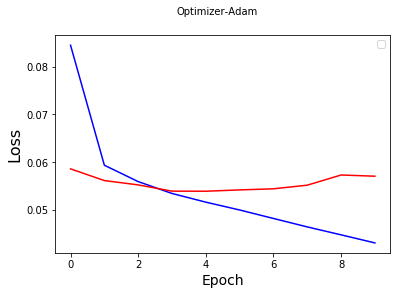

In [0]:
plt.suptitle('Optimizer-Adam', fontsize=10)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc='upper right')
plt.plot(model16.history['loss'], color='b', label='Training Loss')
plt.plot(model16.history['val_loss'], color='r', label='Validation Loss')